# Определение перспективного тарифа для телеком компании
Имеются данные компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо выполнить предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за один год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание данных
Таблица `users` (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана
Таблица `calls` (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок
Таблица `messages` (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение
Таблица `internet` (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя
Таблица `tariffs` (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Общие функции для работы с данными

In [1]:
import matplotlib.pyplot as plt

# Функция print_hist для вывода гистограмм
#  - data - датафрейм или колонка
#  - bins_count - число корзин гистограммы
#  - size - размер рисунка
#  - title - заголовок гистограммы
#  - x_name - название оси абсцисс
#  - y_name - названи оси ординат

def print_hist(data, bins_count, size, plot_title, x_name, y_name):
    data.hist(bins = bins_count, figsize=size)
    plt.grid(True)
    plt.title(plot_title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

## Шаг 1. Открытие файлов с данными и изучение общей информации

In [2]:
import pandas as pd

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Изучим общую информацию по каждому файлу и посмотрим примеры данных.
###  Информация о звонках (calls)

In [3]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


* Параметр `call_date` имеет строковый формат, необходимо преобразовать его к дате.
* Некоторые звонки имеют длительность 0 секунд

### Информация об интернет-сессиях (internet)

In [4]:
internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


В текущем датасете имеется незадокументированная колонка `Unnamed: 0`. Смысловой нагрузки она не несет. По сути ее содержимое равно текущему индексу записи. Нужно будет удалить данную колонку на шаге предобработки данных.

Имеются записи с объем потраченного трафика равен 0.

### Информация о сообщениях (messages):

In [5]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Параметр `message_date` имеет строковый формат, необходимо будет преобразовать эти данные к формату даты.

### Информация о тарифах (tariffs)

In [6]:
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В этом наборе данных проблем не наблюдается.

### Информация о пользователях (users)

In [7]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


* Параметры `churn_date` и `reg_date`
имеют строковый формат, необходимо их преобразовать к датам.
* В параметре с датой прекращения пользования тарифом (`churn_date`) есть пропущенные значения. Но это штатная ситуация: согласно заданию, если значение пропущено, то тариф ещё действовал на момент выгрузки данных.

### Выводы по шагу 1
На основе общей информации видно, что:
* Файлы с данными об интернет-сессиях (`internet`), звонках (`calls`) и сообщениях (`messages`) содержат большое количество записей. Нужно внимательно выбирать методы обработки этих записей, выбирая наименне затратные по производительные решения.
* Параметры с датами необходимо преобразовать из строк в формат с датами.
* В файле с данными об интернет-сессиях (`internet`) имеется лишний столбец, который необходимо удалить.
* Возможно некоторые столбцы с типом `float` лучше перевести в целочисленному типу, округлив значения. Возможно это упростит обработку данных.
* Некоторые звонки имеют длительность 0 секунд, а также с нулевым объемом потраченного трафика. Необходимо решить, что с ними делать и как наше решение повлияет на результаты анализа данных.

## Шаг 2. Подготовка данных
### Приведение данных к нужным типам
#### Приведение к типу дат
Ранее мы обнаружили, что в данных имеются несколько колонок с датами, но они имеют строковый тип. Приведем данные в этих столбцах с типу даты.

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

#### Приведение параметров с типом float к int
В задании сказано, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
Поэтому для упрощения последующего анализа приведем параметры длительности звонка (`calls['duration']`) и объёма потраченного за сессию интернет-трафика (`internet['mb_used']`) к целочисленному типу, округлив значения до большего.

In [9]:
#добавление библиотеки numpy для округления
import numpy as np
#округление значение в большую сторону
calls['duration'] = calls['duration'].apply(np.ceil)
#приведение колонки к типу int
calls['duration'] = calls['duration'].astype('int')
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


In [10]:
#округление значение в большую сторону
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
#приведение колонки к типу int
internet['mb_used'] = internet['mb_used'].astype('int')
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113,2018-11-25,1000
1,1,1000_1,1053,2018-09-07,1000
2,2,1000_2,1198,2018-06-25,1000
3,3,1000_3,551,2018-08-22,1000
4,4,1000_4,303,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,319,2018-10-03,1499
149392,149392,1499_153,491,2018-12-14,1499
149393,149393,1499_154,0,2018-10-27,1499
149394,149394,1499_155,1247,2018-11-26,1499


### Поиск и устранение ошибок в данных
#### Удаление лишней колонки
Удалим ранее найденную лишнюю колонку `Unnamed: 0` из набора данных `internet`:

In [11]:
internet = internet.drop(columns=['Unnamed: 0'])
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB


#### Нулевая продолжительность звонков (calls.duration)
Ранее мы обнаружили нулевые значения в данной колонке. Посмотрим подробнее гистограмму:

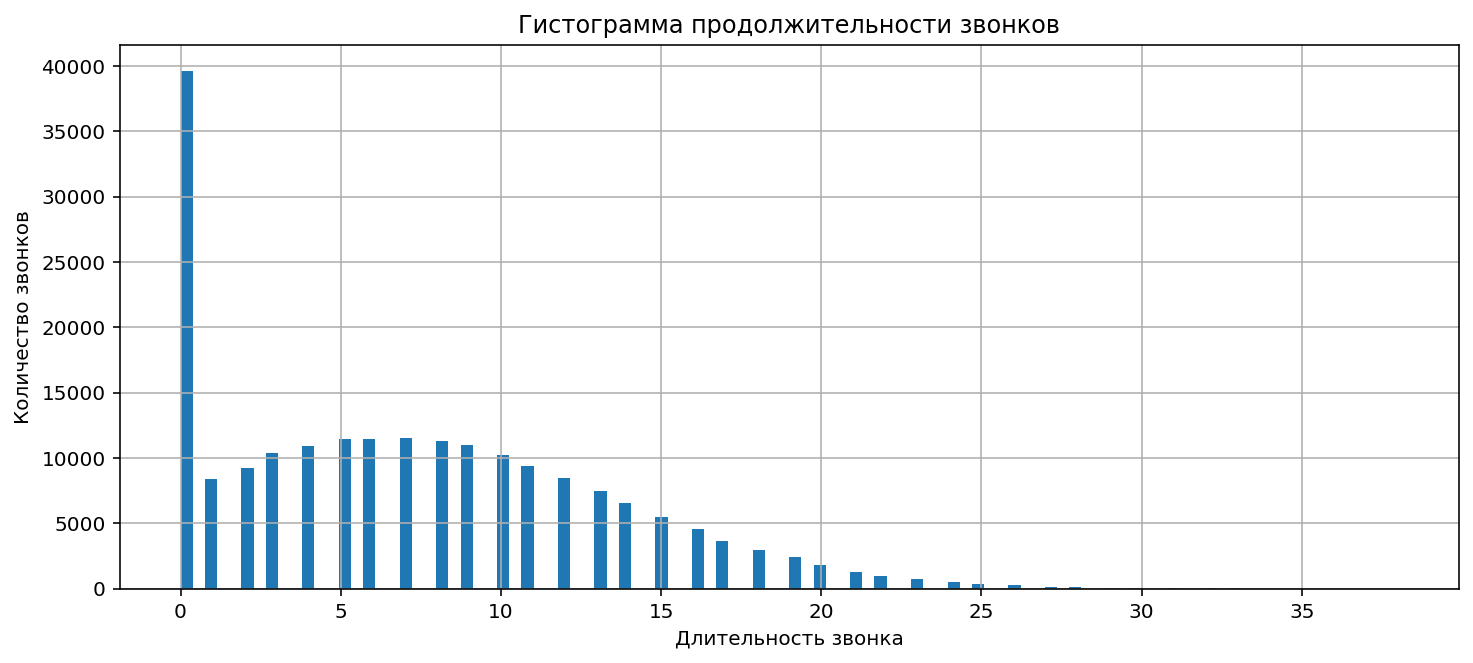

In [12]:
# Улучшим четкость изображения
%config InlineBackend.figure_format = 'retina'
# Построение гистограммы
print_hist(calls['duration'], 100, (12,5),'Гистограмма продолжительности звонков', 'Длительность звонка', 'Количество звонков')

In [13]:
print('Количество записей о звонках продолжительностью 0.0 секунд:',len(calls.query('duration == 0')))

Количество записей о звонках продолжительностью 0.0 секунд: 39613


Скорее всего это неотвеченные исходящие звонки. Как бы то ни было, эти данные не повлияют на результаты анализа, поскольку нам необходима сумма потраченных минут за месяц. Поэтому можно их не удалять.

#### Нулевой расход интернет-трафика (*internet.mb_used*)

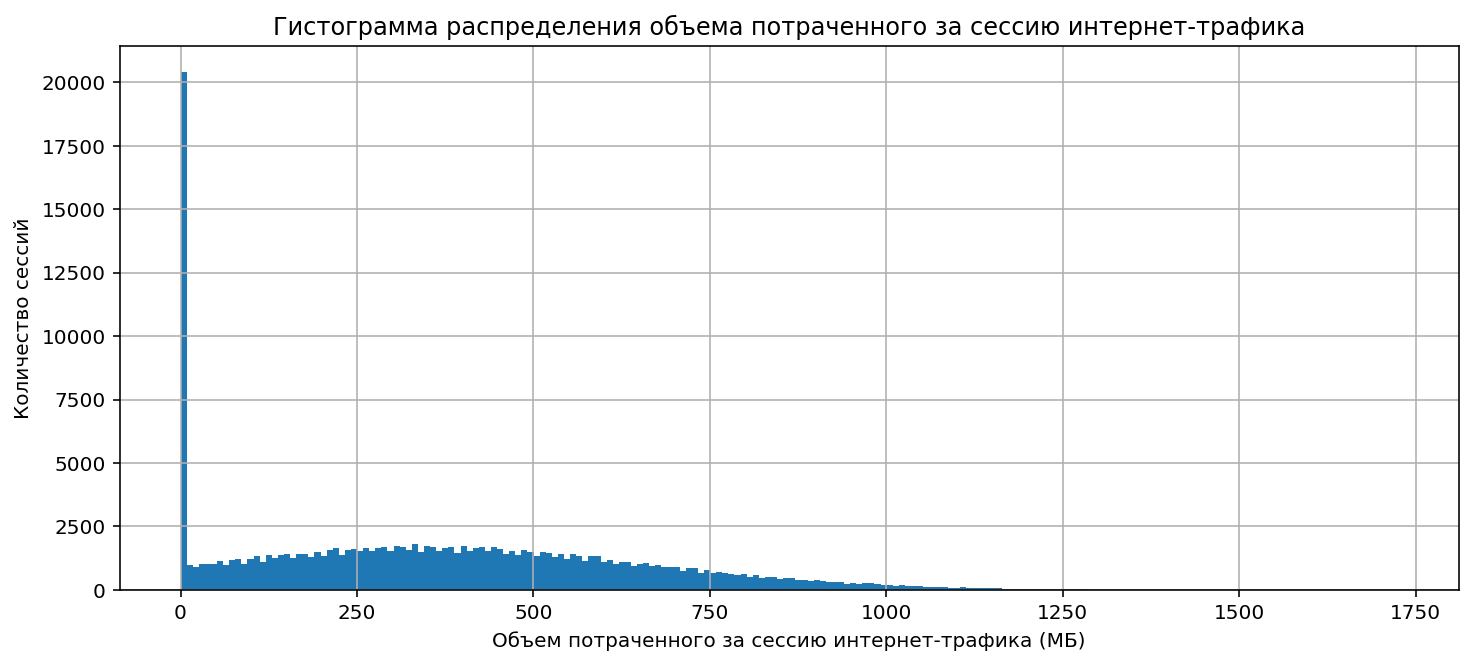

In [14]:
print_hist(internet['mb_used'], 200, (12,5),'Гистограмма распределения объема потраченного за сессию интернет-трафика', 'Объем потраченного за сессию интернет-трафика (МБ)', 'Количество сессий')

Также, как и для звонков, здесь имеется большое количество Интернет-сессий, во время которых не было передано никаких данных. Для наших задач эти значения также неважны, поэтому не будем удалять их.

### Подготовка данных к анализу
Рассчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Чтобы построить сводную статистику звонков по месяцам добавим колонку *calls.month* на основе *calls.call_date*, в которой будет содержаться первый день месяца совершения звонка.

In [15]:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

Создадим датафрейм `calls_stat` с помесячной информацией о суммарном количестве сделанных звонков и израсходованных минут разговора по каждому пользователю

In [16]:
# Создание датафрейма calls_stat с помесячной информацией о количестве сделанных звонков и израсходованных минут разговора по каждому пользователю
calls_stat = calls.groupby(['user_id','month'])[['duration']].agg(['count','sum']).reset_index()
# Переименуем столбцы датафрейма
calls_stat.columns = ['user_id','month','calls','minutes']
# Посмотрим, что получилось
calls_stat.head()

,user_id,month,calls,minutes
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466


Теперь аналогично для построения сводной статистики количества отправленных сообщений по месяцам добавим колонку *messages.month* на основе *messages.message_date*, в которой будет содержаться первый день месяца совершения звонка.

In [17]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

Создадим датафрейм messages_stat с помесячной информацией о количестве отправленных сообщений по каждому пользователю

In [18]:
messages_stat = calls.groupby(['user_id','month'])[['id']].agg(['count']).reset_index()
messages_stat.columns = ['user_id','month','messages']
messages_stat.head()

,user_id,month,messages
0,1000,2018-05-01,22
1,1000,2018-06-01,43
2,1000,2018-07-01,47
3,1000,2018-08-01,52
4,1000,2018-09-01,58


Чтобы построить сводную статистику израсходованного интернет-трафика по месяцам добавим колонку *internet.month* на основе *internet.session_date*, в которой будет содержаться первый день месяца совершения звонка.

In [19]:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

Создадим датафрейм internet_stat с помесячной информацией об израсходованном интернет-трафике по каждому пользователю

In [20]:
internet_stat = internet.groupby(['user_id','month'])[['mb_used']].agg(['sum']).reset_index()
internet_stat.columns = ['user_id','month','internet']
internet_stat.head()

,user_id,month,internet
0,1000,2018-05-01,2256
1,1000,2018-06-01,23257
2,1000,2018-07-01,14016
3,1000,2018-08-01,14070
4,1000,2018-09-01,14581


Поскольку тарификация производится по гигибайтам, то преобразуем значение в колонке `internet_stat['internet']` из МБ в ГБ, а затем округлим значение до целого в большую сторону:

In [21]:
# преобразование из МБ в ГБ (1 гигабайт = 1024 мегабайт)
internet_stat['internet'] = internet_stat['internet'] / 1024
# округление значение в большую сторону
internet_stat['internet'] = internet_stat['internet'].apply(np.ceil)
# приведение колонки к типу int
internet_stat['internet'] = internet_stat['internet'].astype('int')

Теперь создадим датафрейм *users_stat*, в котором объединим сводные данные по расходу минут, сообщений и интернет-трафика.

In [22]:
# запишем в переменную min_month минимальный месяц в выборке по звонкам
min_month = calls['call_date'].values.astype('datetime64[M]').min()
# запишем в переменную max_month максимальный месяц в выборке по звонкам
max_month = calls['call_date'].values.astype('datetime64[M]').max()
# создаем датафрейм с месяцами от минимального до максимального
months = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))
# переименуем столбец датафрейма
months.columns = ['month']
# выведем на экран полученный датафрейм
months

,month
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


Также перед объединением таблицы добавим в таблицу с пользователями `users` колонки с месяцем регистрации `reg_month` и месяцем отключения от тарифа `churn_month`:

In [23]:
users['reg_month'] = users['reg_date'].values.astype('datetime64[M]')
users['churn_month'] = users['churn_date'].values.astype('datetime64[M]')

Для объединения данных из таблиц пользователей `users` и месяцев `months` сделаем кросс-джойн:

In [24]:
# добавляем в users столбец заполненный значением 1
users['key'] = 1
# добавляем в months столбец заполненный значением 1
months['key'] = 1
# выполняем объединение таблиц по колонке key
users_stat = months.merge(users,on='key')
# вывод на экран объединенной таблицы
users_stat.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month
0,2018-01-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,NaT
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01,NaT
2,2018-01-01,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-01,NaT
3,2018-01-01,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-01,NaT
4,2018-01-01,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-01,NaT


Проверим, сколько записей получилось. Должно быть 500 * 12 = 6000:

In [25]:
print('Количество записей с помесчной статистикой по пользователям:',len(users_stat))

Количество записей с помесчной статистикой по пользователям: 6000


В полученном датафрейме `users_stat` присутствует много записей с месяцем ранее месяца регистрации пользователя (`reg_month`), а также записи с месяцем позднее месяца отключения пользователя от тарифа (`churn_month`). Поэтому нет смысла хранить такие записи в `users_stat`, они только будут мешать корректному подсчету статистики.

Для корректной работы со столбцом `churn_month` необходимо заполнить пропущенные значения. Поскольку пропущенные значения в данном параметре означают, что на конец 2018 года пользователь продолжал использовать тариф, то заменим пропущенные значения на техническую дату, которая больше декабря 2018 года (например, ноябрем 2020 года):

In [26]:
users_stat['churn_month'] = users_stat['churn_month'].fillna(value=pd.to_datetime('2020-11-01', format='%Y-%m-%d'))
print('Количество записей, в которых текущий месяц раньше месяца регистрации пользователя:',len(users_stat[users_stat['month'] < users_stat['reg_month']]))
print('Количество записей, в которых текущий месяц позже месяца отключения пользователя',len(users_stat[users_stat['month'] > users_stat['churn_month']]))

Количество записей, в которых текущий месяц раньше месяца регистрации пользователя: 2741
Количество записей, в которых текущий месяц позже месяца отключения пользователя 43


Также желательно удалить записи с месяцами, равными месяцу регистрации пользователи, а также равными месяцу отключения. Абоненты в такие месяцы могли быть активными только часть дней. Поэтому такие данные могут сильно повлиять на статистику.

In [27]:
print('Количество записей, в которых текущий месяц раньше месяца регистрации пользователя:',len(users_stat[users_stat['month'] == users_stat['reg_month']]))
print('Количество записей, в которых текущий месяц позже месяца отключения пользователя',len(users_stat[users_stat['month'] == users_stat['churn_month']]))

Количество записей, в которых текущий месяц раньше месяца регистрации пользователя: 500
Количество записей, в которых текущий месяц позже месяца отключения пользователя 38


Теперь удалим лишние записи из датафрейма:

In [28]:
users_stat = users_stat[(users_stat['month'] > users_stat['reg_month'])&(users_stat['month'] < users_stat['churn_month'])]

Также удалим лишние колонки. Нам больше не потребуется техническая колонка `key`. Также точно нет необходимости в именах пользователей, конкретной дате регистрации и отключения.

In [29]:
users_stat = users_stat.drop(columns=['key','first_name','last_name','reg_date','churn_date'])

Объедимим в users_stat сводные данные по расходу минут, сообщений и интернет-трафика:

In [30]:
users_stat = users_stat.merge(calls_stat,how='left',on=['user_id','month'])
users_stat = users_stat.merge(internet_stat,how='left',on=['user_id','month'])
users_stat = users_stat.merge(messages_stat,how='left',on=['user_id','month'])

В новом датафрейме сводные параметры имеют тип `float`. Стоит пребразовать их в целочисленный тип, предварительно заполнив пропущенные значения. Пропущенные значение в данном случае означают, что пользователь в рассматриваемом месяце не совершал звонков (`calls = NaN`), или не использовал Интернет (`internet = NaN`), или не отправлял сообщения (`messages = NaN`).

In [31]:
# Заполнение пустых значений
users_stat['calls'] = users_stat['calls'].fillna(value=0)
users_stat['minutes'] = users_stat['minutes'].fillna(value=0)
users_stat['internet'] = users_stat['internet'].fillna(value=0)
users_stat['messages'] = users_stat['messages'].fillna(value=0)

# Преобразование колонок в тип int
users_stat = users_stat.astype({"calls": int, "minutes": int, "internet": int, "messages": int})

Добавим в `users_stat` колонку `revenue`, в которой рассчитаем по каждому пользователю выручку по месяцам в зависимости от используемого тарифа. Для расчета создадим функцию `revenue_calc`:

In [32]:
def revenue_calc(tariff, minutes, internet, messages):
    
    if tariff == 'smart':
        revenue = 550
        if minutes > 500:
            revenue += (minutes - 500) * 3
        if internet > 15:
            revenue += (internet - 15) * 200
        if messages > 50:
            revenue += (messages - 50) * 3
            
    elif tariff == 'ultra':
        revenue = 1950
        if minutes > 3000:
            revenue += (minutes - 3000) * 3
        if internet > 30:
            revenue += (internet - 30) * 200
        if messages > 1000:
            revenue += (messages - 1000) * 3
            
    return revenue

Применим реализованную функцию к `users_stat`, записав значение выручки в колонку `revenue`.

In [33]:
users_stat['revenue'] = users_stat.apply(lambda x: revenue_calc(x.tariff, x.minutes, x.internet, x.messages), axis=1)

Посмотрим на примеры записей полученных расчетов в `users_stat`:

In [34]:
users_stat

,month,user_id,age,city,tariff,reg_month,churn_month,calls,minutes,internet,messages,revenue
0,2018-02-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,69,456,8,69,607
1,2018-02-01,1032,31,Ульяновск,smart,2018-01-01,2020-11-01,58,371,13,58,574
2,2018-02-01,1045,48,Улан-Удэ,smart,2018-01-01,2020-11-01,27,189,15,27,550
3,2018-02-01,1055,39,Казань,smart,2018-01-01,2020-11-01,66,440,15,66,598
4,2018-02-01,1071,20,Омск,smart,2018-01-01,2018-08-01,54,401,15,54,562
...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2018-12-01,1494,62,Омск,smart,2018-08-01,2020-11-01,62,418,18,62,1186
2676,2018-12-01,1495,65,Иркутск,ultra,2018-08-01,2020-11-01,155,1031,23,155,1950
2677,2018-12-01,1496,36,Вологда,smart,2018-01-01,2020-11-01,80,518,21,80,1894
2678,2018-12-01,1497,32,Челябинск,smart,2018-10-01,2020-11-01,71,545,20,71,1748


Посмотрим на пример данных по одному пользователю:

In [35]:
users_stat[users_stat['user_id'] == 1005]

,month,user_id,age,city,tariff,reg_month,churn_month,calls,minutes,internet,messages,revenue
0,2018-02-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,69,456,8,69,607
43,2018-03-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,77,606,11,77,949
125,2018-04-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,101,712,10,101,1339
239,2018-05-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,73,595,8,73,904
408,2018-06-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,80,612,10,80,976
617,2018-07-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,77,569,8,77,838
865,2018-08-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,71,619,8,71,970
1156,2018-09-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,66,479,7,66,598
1493,2018-10-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,100,723,8,100,1369
1856,2018-11-01,1005,67,Набережные Челны,smart,2018-01-01,2020-11-01,75,547,13,75,766


### Выводы по шагу 2
В результате проведенной предобратки данных было сделано следующее:
* приведены данные к нужным типам
* удалена лишняя колонка
* добавлен датафрейм, в котором для каждого пользователя рассчитаны:
    * количество сделанных звонков и израсходованных минут разговора по месяцам;
    * количество отправленных сообщений по месяцам;
    * объем израсходованного интернет-трафика по месяцам;
    * помесячная выручка сотового оператора с каждого пользователя.

## Шаг 3. Анализ данных
Посмотрим подробнее полученную на предыдущем шаге помесячную статистику для клиентов оператора связи.
### Минуты разговора
Посмотрим, сколько пользователи каждого тарифа тратят минут разговора в месяц. Построим для данного параметра сводную таблицу в разбивке по тарифам со следующими параметрами:

* **mean** - среднее количество
* **median** - медиана
* **std** - стандартное отклонение
* **var** - дисперсия

In [36]:
users_stat.groupby('tariff')['minutes'].agg(['mean','median','std','var'])

,mean,median,std,var
tariff,,,,
smart,453.003770,454,176.314672,31086.863671
ultra,572.928311,565,307.242082,94397.696801


Также построим гистограммы распределения потраченных минут в разбивке по тарифамм. Для наглядности выведем обе гистограммы на один график.

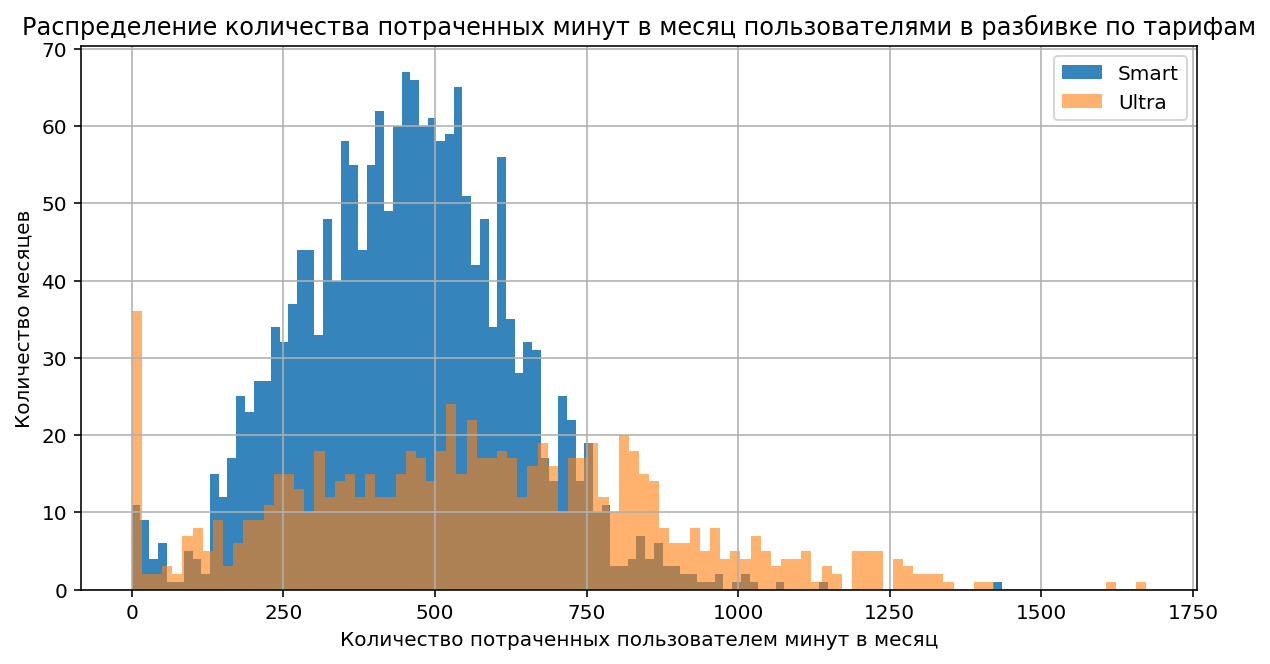

In [37]:
users_stat[users_stat['tariff'] == 'smart']['minutes'].hist(bins=100, figsize=(10, 5), alpha = 0.9)
users_stat[users_stat['tariff'] == 'ultra']['minutes'].hist(bins=100, alpha = 0.6)
plt.grid(True)
labels= ["Smart","Ultra"]
plt.legend(labels)
plt.title('Распределение количества потраченных минут в месяц пользователями в разбивке по тарифам')
plt.xlabel('Количество потраченных пользователем минут в месяц')
plt.ylabel('Количество месяцев')
plt.show()

* В среднем пользователям тарифа *smart* требуется около 450 минут разговоров в месяц. Это очень близко к лимиту данного тарифа (500 минут). И как видно по гистограмме, значительная часть пользователей данного тарифа покупают дополнительные минуты сверх лимита.
* Пользователи тарифа *ultra* расходуют в среднем около 570 минут разговоров в месяц, что больше среднего для пользователей тарифа *smart*. Причем нет ни одного месяца, когда кто-то из рассматриваемых пользователей вышел за пределы лимита тарифа (3000 минут), т.е. данный лимит для пользователей тарифа *ultra* оказывается очень большим.
* Есть большое количество случаев, когда пользователи тарифа *ultra* совсем не разговаривают по телефону. Возможно они покупали этот тариф из-за увеличенного лимита по другой опции (скорее всего Интернет).
* По высоте гистограммы видно, что пользователй тарифом *smart* значительно больше, чем тарифом *ultra*, что логично ввиду дешевизны тарифа *smart*.

### Интернет-трафик
Построим для данного параметра сводную таблицу в разбивке по тарифам, а также гистограмму распределения аналогично тому, что мы делали для минут.

In [38]:
users_stat.groupby('tariff')['internet'].agg(['mean','median','std','var'])

,mean,median,std,var
tariff,,,,
smart,17.670436,17,4.805613,23.093915
ultra,21.216282,21,9.262691,85.797447


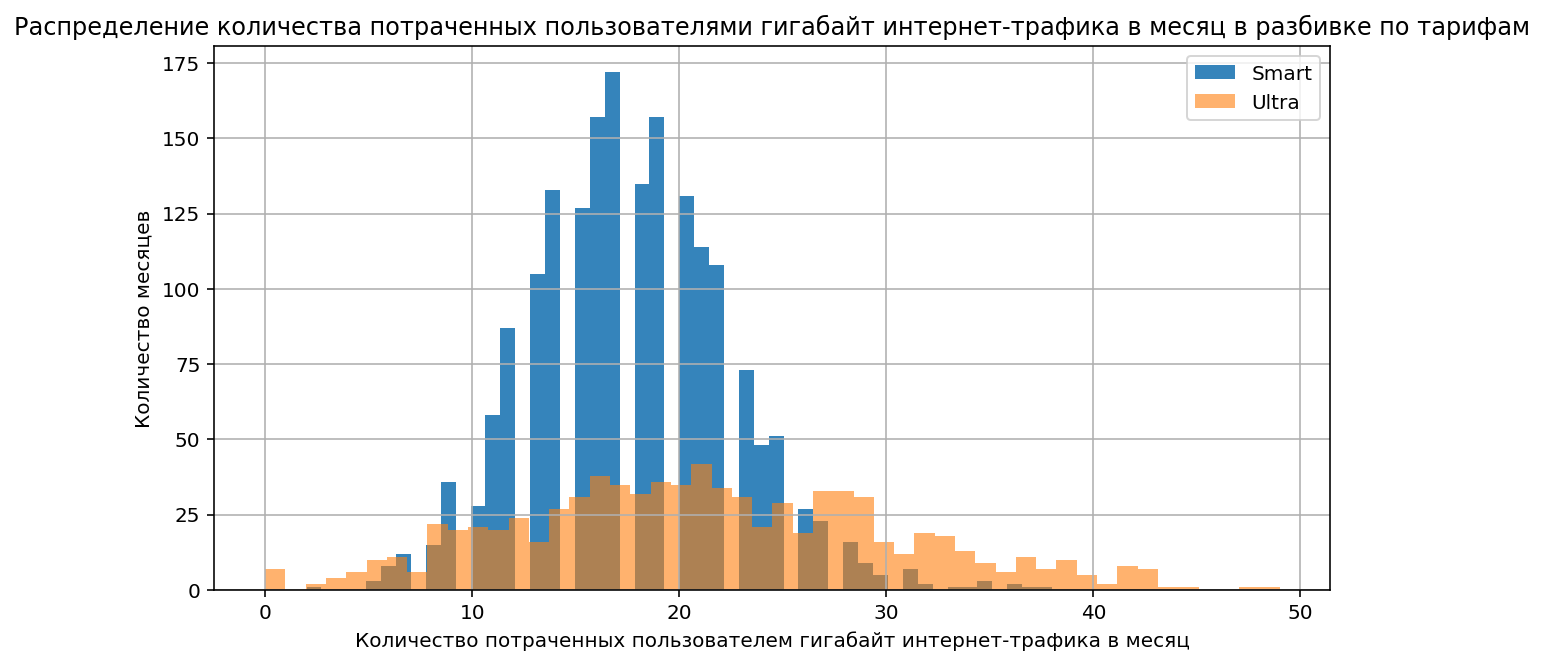

In [39]:
users_stat[users_stat['tariff'] == 'smart']['internet'].hist(bins=50, figsize=(10, 5), alpha = 0.9)
users_stat[users_stat['tariff'] == 'ultra']['internet'].hist(bins=50, alpha = 0.6)
plt.grid(True)
labels= ["Smart","Ultra"]
plt.legend(labels)
plt.title('Распределение количества потраченных пользователями гигабайт интернет-трафика в месяц в разбивке по тарифам')
plt.xlabel('Количество потраченных пользователем гигабайт интернет-трафика в месяц')
plt.ylabel('Количество месяцев')
plt.show()

* В среднем пользователям тарифа *smart* требуется 17 ГБ интернет-трафика, что даже больше лимита тарифа (15 ГБ). Т.е. большая часть пользователей данного тарифа переплачивает за Интернет.
* Пользователям тарифа *ultra* тратят в среднем чуть больше, чем пользователи тарифа *smart* - 21 ГБ. При этом для значительного количества пользователей тарифа *ultra* не хватает для покрытия своих потребностей даже лимита в 30 ГБ.

### Сообщения
Построим для данного параметра сводную таблицу в разбивке по тарифам, а также гистограмму распределения аналогично тому, что мы делали для потраченных минут и Интернет-трафика.

In [40]:
users_stat.groupby('tariff')['messages'].agg(['mean','median','std','var'])

,mean,median,std,var
tariff,,,,
smart,63.420032,64,23.805181,566.686624
ultra,79.883354,80,42.416525,1799.161560


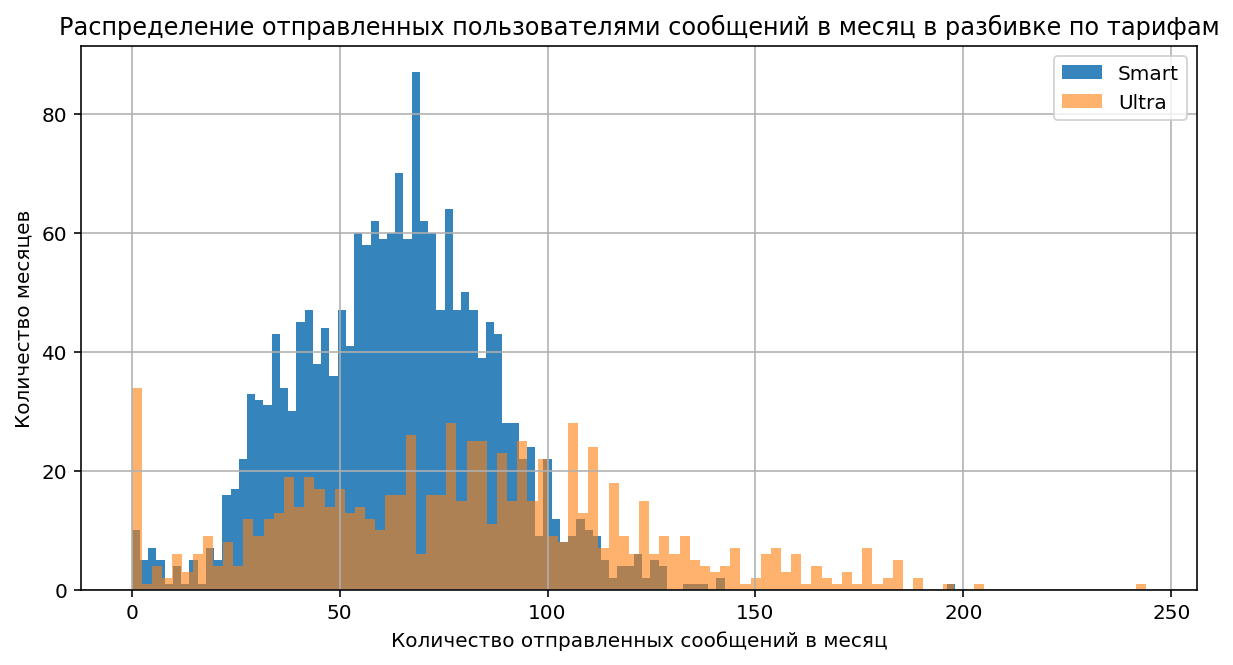

In [41]:
users_stat[users_stat['tariff'] == 'smart']['messages'].hist(bins=100, figsize=(10, 5), alpha = 0.9)
users_stat[users_stat['tariff'] == 'ultra']['messages'].hist(bins=100, alpha = 0.6)
plt.grid(True)
labels= ["Smart","Ultra"]
plt.legend(labels)
plt.title('Распределение отправленных пользователями сообщений в месяц в разбивке по тарифам')
plt.xlabel('Количество отправленных сообщений в месяц')
plt.ylabel('Количество месяцев')
plt.show()

* В среднем пользователям тарифа *smart* требуется 63 сообщения в месяц, что больше лимита тарифа (50 сообщение). Т.е. большая часть пользователей данного тарифа переплачивает за отправляемые сообщения.
* Пользователи тарифа *ultra* отправляют в среднем больше сообщений, чем пользователи тарифа smart - 80. При этом никто из рассматриваемых пользователей не выходит за пределы лимита тарифа (1000 сообщений)

### Помесячная выручка
Также построим для данного параметра сводную таблицу в разбивке по тарифам, а также гистограмму распределения.

In [42]:
users_stat.groupby('tariff')['revenue'].agg(['mean','median','std','var'])

,mean,median,std,var
tariff,,,,
smart,1445.956920,1235,849.821033,722195.788014
ultra,2140.765492,1950,546.176511,298308.780706


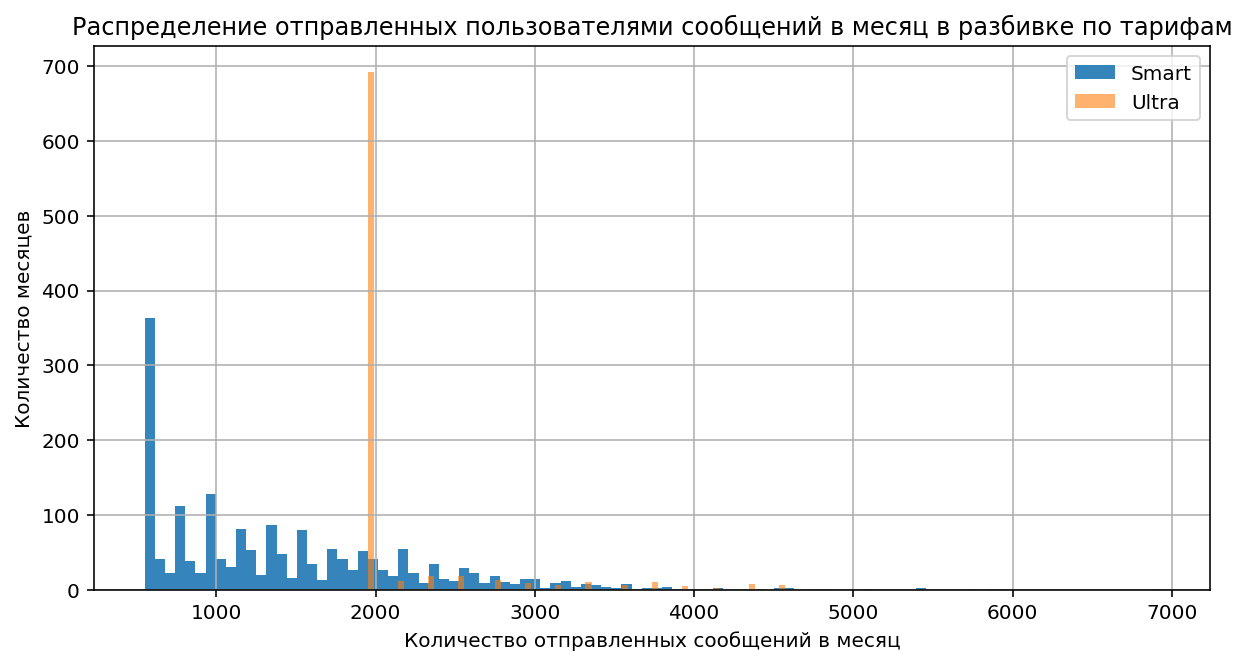

In [43]:
users_stat[users_stat['tariff'] == 'smart']['revenue'].hist(bins=100, figsize=(10, 5), alpha = 0.9)
users_stat[users_stat['tariff'] == 'ultra']['revenue'].hist(bins=100, alpha = 0.6)
plt.grid(True)
labels= ["Smart","Ultra"]
plt.legend(labels)
plt.title('Распределение отправленных пользователями сообщений в месяц в разбивке по тарифам')
plt.xlabel('Количество отправленных сообщений в месяц')
plt.ylabel('Количество месяцев')
plt.show()

* Из-за того, что пользователи тарифа *smart* часто выходят за пределы лимитов, среднее значение выручки оператора от пользователей данным тарифом значительно больше абонентской платы (почти в 3 раза), таким образом, оказывается близко к абонентской плате тарифа *ultra*.
* Чаще всего пользователи тарифа *ultra* не исчерпывают ежемесячных лимитов. В результате медиана равна ровно 1950, а среднее значение очень близко к значению абонентской платы.

### Выводы по шагу 3
* Пользователи тарифа *ultra* тратят в среднем больше минут (примерно на 20%), трафика и сообщений, чем пользователи тарифа *smart*. Тем не менее, эта разница несоразмерна абонентской плате, которая в 3 раза больше у пользователей тарифа *ultra*.
* Пользователи тарифа *smart* зачастую значительно переплачивают за счет того, что выходят за лимиты пакета. Переплата сверх лимита составляет в среднем в два раза больше, чем абонентская плата.
* Пользователи тарифа *ultra* редко выходят за пределы лимитов. В основном им хватает имеющегося пакета. При этом выходят за лимиты только по Интернет-трафику.

## Шаг 4. Проверка гипотез

На данном шаге нам необходимо проверить следующие гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверки гипотез воспользуемся методом, который возвращает статистику разности между средними значениями.
В обоих гипотезах мы будем сравнивать между собой средние двух генеральных совокупностей, поэтому будем использовать метод `scipy.stats.ttest_ind()`.

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт»
Проверим гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Сначала сформулируем нулевую гипотезу. Она всегда формулируется так, чтобы использовать знак равенства. Поэтому нулевая гипотеза будет звучать следующим образом:

**Н0: Средняя выручка оператора от пользователей тарифа «Ультра» равна средней выручке от пользователей тарифа «Смарт».**

Тогда альтернативная гипотеза будет звучать так:

**Н1: Средняя выручка оператора от пользователей тарифа «Ультра» отличается от средней выручки от пользователей тарифа «Смарт».**

Рассчитаем средние значения выручки от пользователей по рассматриваемым тарифам:

In [44]:
print('Средняя выручка от абонентов тарифа «Смарт»:',users_stat[users_stat['tariff'] == 'smart']['revenue'].mean())
print('Средняя выручка от абонентов тарифа «Ультра»:',users_stat[users_stat['tariff'] == 'ultra']['revenue'].mean())

Средняя выручка от абонентов тарифа «Смарт»: 1445.9569197630587
Средняя выручка от абонентов тарифа «Ультра»: 2140.7654921020658


Средние выручки заметно отличаются. Но это различие могло получиться и случайно. Осуществим проверку сформулированной гипотезы.

In [45]:
from scipy import stats as st

# Зададим критический уровень статистической значимости
alpha = .05

# Проведем тест и посчитаем p-значение
results = st.ttest_ind(
    users_stat[users_stat['tariff'] == 'smart']['revenue'],
    users_stat[users_stat['tariff'] == 'ultra']['revenue'])

# Выведем на экран полученное p-значение
print('p-значение: ', results.pvalue)

# Сравним получившееся p-значение с заданным уровнем статистической значимости:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  3.178555418340759e-95
Отвергаем нулевую гипотезу


Вероятность того, что средние выручки от пользователей тарифами «Ультра» и «Смарт» будут равны, оказалась почти нулевой.
Поэтому можно сделать вывод, что средние выручки действительно различны.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Сформулируем нулевую гипотезу:

**Н0: Средняя выручка от пользователей из Москвы равна средней выручке от пользователей из других регионов.**

Тогда альтернативная гипотеза будет звучать так:

**Н1: Средняя выручка от пользователей из Москвы отлична от средней выручки от пользователей из других регионов.**

Для наглядности рассчитаем среднюю выручку по рассматриваемым группам:

In [46]:
print('Средняя выручка от абонентов из Москвы:',users_stat[users_stat['city'] == 'Москва']['revenue'].mean())
print('Средняя выручка от абонентов из других регионов:',users_stat[users_stat['city'] != 'Москва']['revenue'].mean())

Средняя выручка от абонентов из Москвы: 1689.8608349900596
Средняя выручка от абонентов из других регионов: 1652.2700964630226


Расчетные значения мало отличаются друг от друга. Но они могли получиться и случайно. Осуществим проверку сформулированной гипотезы.

In [47]:
# Зададим критический уровень статистической значимости
alpha = .05

# Проведем тест и посчитаем p-значение
results = st.ttest_ind(
    users_stat[users_stat['city'] == 'Москва']['revenue'],
    users_stat[users_stat['city'] != 'Москва']['revenue'])

# Выведем на экран полученное p-значение
print('p-значение: ', results.pvalue)

# Сравним получившееся p-значение с заданным уровнем статистической значимости:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.3620251030578018
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что с вероятностью в 36% текущее различие между средними выручками от пользователей из рассматриваемых групп можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками от пользователей из Москвы в сравнении с пользователями из других регионов.

### Выводы по шагу 4

В результате проверки сформулированных гипотез выяснено следующее:
* Средняя выручка сотового оператора от пользователей тарифов «Ультра» и «Смарт» различается.
* Средняя выручка сотового оператора от пользователей из Москвы не отличается от выручки от пользователей из других регионов.

## Шаг 5. Общий вывод
Проведенный анализ позволил ответить на изначально поставленный вопрос о том, какой тариф лучше:
* С точки зрения средней выручки для оператора лучше оказывается тариф «Ультра»: средняя помясячная выручка от него значительно больше по сравнению с тарифом «Смарт» (примерно на 50%).
* Тариф «Смарт» может быть более привлекателен для пользователей с точки зрения абонентской платы, что и подтверждается тем, что пользователей данного тарифа значительно больше, чем пользователей тарифа «Ультра». 
* В то же время существенным недостатком тарифа «Смарт» является худшая предсказуемость ежемесячного платежа, поскольку его пользователи часто выходят за предоставляемые лимиты. С одной стороны, это выгодно сотовому оператору. С другой стороны, пользователи ожидают, что будут платить минимум - абонентскую плату. Частые же выходы за лимиты приводят к их недовольству и стремлению оптимизировать траты, т.е. либо сменить тариф, либо оператора связи.